In [2]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import AJA as aja
from torch_geometric.loader import DataLoader

In [3]:
# charge les data frame brut (avec bert par défaut mais on peut l'enlever)

df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

In [4]:
df_train_nodes.head()

,transcription,line,speaker_int,speaker_text,text,label,bert_0,bert_1,bert_2,bert_3,...,bert_374,bert_375,bert_376,bert_377,bert_378,bert_379,bert_380,bert_381,bert_382,bert_383
0,ES2002a,0,0,PM,Okay,0,-0.057809,-0.085828,-0.035720,-0.011185,...,0.018063,-0.033183,-0.004249,-0.026428,0.074381,0.010209,0.085386,-0.014607,0.058432,-0.009739
1,ES2002a,1,0,PM,Right,0,-0.054862,0.047607,-0.032626,-0.010949,...,0.092259,0.034839,-0.021490,0.007297,0.027587,0.027128,0.145950,0.037911,0.073511,0.079932
2,ES2002a,2,0,PM,<vocalsound> Um well this is the kick-off meet...,1,-0.054665,-0.073837,-0.017161,-0.064276,...,0.035382,0.098955,-0.025984,0.077994,0.003580,0.032260,0.022304,0.059096,-0.036019,-0.008820
3,ES2002a,3,0,PM,Um <vocalsound> and um,0,-0.010416,-0.072719,-0.017206,-0.088992,...,0.006533,0.032185,0.010955,0.041298,-0.018026,0.050856,0.007696,0.041694,0.077368,-0.037393
4,ES2002a,4,0,PM,this is just what we're gonna be doing over th...,0,-0.028654,-0.015151,0.095910,-0.059113,...,0.108833,0.061266,-0.011521,-0.010543,0.010692,0.117780,-0.017561,-0.028903,0.007401,-0.005552


In [5]:
# on bricole ses data frame en définissant des fonction qui prennent en entré un dataframe
# et donne en sortie un dataframe
# c'est dans ces fonctions qu'on extrait les features 

# fonction d'extraction de feature pour les noeuds
def f(df):
    df_modif = aja.basic_node_extraction(df)
    return df_modif

# fonction d'extraction de feature pour les arrêtes
def g(df):
    df_modif = aja.identity(df)
    return df_modif


In [6]:
# on crée les graphes de train, validation et test en donnant les fonctions d'feature-extraction
# de features et le ratio de validation (les vraies données de bases sont rechargées
# et la même transformation est appliquée au train et au test !) 

train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

In [7]:
# on check la forme des data

train_graphs
# ici les noeuds ont 386 features

{'IS1003c': Data(x=[869, 386], edge_index=[16], y=[869]),
 'ES2016b': Data(x=[713, 386], edge_index=[16], y=[713]),
 'ES2008b': Data(x=[856, 386], edge_index=[16], y=[856]),
 'IS1002d': Data(x=[497, 386], edge_index=[16], y=[497]),
 'ES2009a': Data(x=[791, 386], edge_index=[16], y=[791]),
 'IS1001c': Data(x=[515, 386], edge_index=[16], y=[515]),
 'ES2006c': Data(x=[869, 386], edge_index=[16], y=[869]),
 'ES2015b': Data(x=[973, 386], edge_index=[16], y=[973]),
 'IS1000c': Data(x=[722, 386], edge_index=[16], y=[722]),
 'TS3009c': Data(x=[1275, 386], edge_index=[16], y=[1275]),
 'IS1004d': Data(x=[886, 386], edge_index=[16], y=[886]),
 'TS3012d': Data(x=[1283, 386], edge_index=[16], y=[1283]),
 'TS3009a': Data(x=[714, 386], edge_index=[16], y=[714]),
 'TS3011a': Data(x=[486, 386], edge_index=[16], y=[486]),
 'ES2016a': Data(x=[481, 386], edge_index=[16], y=[481]),
 'IS1005a': Data(x=[249, 386], edge_index=[16], y=[249]),
 'ES2009d': Data(x=[1082, 386], edge_index=[16], y=[1082]),
 'ES2013

In [8]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.channels = channels
        self.sc1 = 40
        self.f1 = 50
        self.sc2 = 30
        self.GCN1 = nn.ModuleList([GCNConv(input_dim, self.sc1) for _ in range(channels)])
        self.dense1 = nn.Linear(self.sc1*channels, self.f1)
        self.GCN2 = nn.ModuleList([GCNConv(self.f1, self.sc2) for _ in range(channels)])
        self.dense2 = nn.Linear(self.sc2*channels, 2)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        # Appliquez les couches GCN avec une activation ReLU entre elles
        x1 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc1)
            else:
                x = F.relu(self.GCN1[k](nodes, edges[k]))
            x1.append(x)
        x1_f = torch.cat(x1, dim=1)

        f1 = F.relu(self.dense1(x1_f))

        x2 = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.sc2)
            else:
                x = F.relu(self.GCN2[k](f1, edges[k]))
            x1.append(x)
            x2.append(x)
        x2_f = torch.cat(x2, dim=1)

        x_out = self.dense2(x2_f)

        return F.log_softmax(x_out, dim=1)

In [9]:
# on instancie le modèle
model = NodeClassifier(16,386)

# on définie la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch: 000, Loss: 29.2059
F1-score: 0.05103885301423992
Epoch: 001, Loss: 23.2214
F1-score: 0.5200132379254179
Epoch: 002, Loss: 22.9641
F1-score: 0.471378209298485
Epoch: 003, Loss: 22.6543
F1-score: 0.4580858078383928
Epoch: 004, Loss: 22.2792
F1-score: 0.4334970795565155
-------------------------
Analyse des performance du modèle :
-------------------------
F1-score: 0.4334970795565155


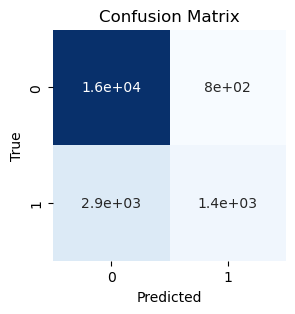

In [10]:
# on entraine !

for epoch in range(5):
    loss = aja.train(model, train_graphs, optimizer, criterion)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    aja.test_during_training(model, validation_graphs)

# on analyse le modèle
aja.analyse_model(model, validation_graphs)

In [15]:
# quand on est content on fait une submission !

aja.make_test_csv_submission(model, test_graphs, 'test_pipeline')